# Table of Contents

1. [Importing Libraries](#1.-Importing-Libraries)
2. [Getting the data](#2.-Getting-the-data)
3. [Config and Functions](#3.-Config-and-Functions) <br>
    3.1 [Config](#3.1-Config) <br>
    3.2 [Functions](#3.2-Functions)
4. [Visualization](#4.-Visualization) <br>
    4.1 [Largest producers / consumers per commodity](#Largest-producers-/-consumers-per-commodity) <br>
    4.2 [Balance between production and consumption in respective origin countries](#Balance-between-production-and-consumption-in-respective-origin-countries-in-2020) <br>
    4.3 [Percentage of consumption of commodity for the largest producers](#Percentage-of-consumption-of-commodity-for-the-largest-producers) <br>
    4.4 [Stock level balance throughout the years](#Stock-level-balance-throughout-the-years) <br>
    4.5 [Top 7 Exporters per Commodity in a year](#4.5-Top-7-Exporters-per-Commodity-in-a-year)

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# 2. Getting the data

In [2]:
# commodities_link = 'https://apps.fas.usda.gov/psdonline/downloads/psd_alldata_csv.zip'
commodities_file = 'data/psd_alldata_csv.zip'

all_commodities = pd.read_csv(commodities_file, 
                              compression='zip',
                              keep_default_na=False)

In [3]:
commodities_to_explore = \
    ['Grapefruit, Fresh',
     'Lemons/Limes, Fresh',
     'Oranges, Fresh',
     'Tangerines/Mandarins, Fresh',
     'Coffee, Green']

commodities = (all_commodities
                   [all_commodities.Commodity_Description.isin(commodities_to_explore)]
                   .copy()
                   .reset_index(drop=True))

# 3. Config and Functions 

## 3.1 Config

In [4]:
# dataframe style
heading_properties = [('font-size', '16px')]
cell_properties = [('font-size', '15px')]
dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

## 3.2 Functions

In [5]:
# manipulation

def filter_by_values(df: pd.DataFrame, column: str, values: list):
    
    return df[df[column].isin(values)].copy()


def filter_by_index(df: pd.DataFrame, value):
    
    return df.loc[value].copy().reset_index()


def groupby_and_sum_values(df: pd.DataFrame, group: list):
        
    return df.groupby(group).sum('Value')[['Value']]


def get_top_countries_per_commodity(df_attr: pd.DataFrame, column_title: str):

    commodities_sum_value_per_country = \
        groupby_and_sum_values(df_attr, ['Commodity_Description', 'Country_Name'])

    commodities_max_values = \
        commodities_sum_value_per_country.groupby(['Commodity_Description']).max()#idxmax()

    return (commodities_max_values
                .merge(commodities_sum_value_per_country.reset_index())
                .rename(columns={'Commodity_Description': 'Commodity',
                                 'Country_Name': column_title})
                .sort_values(column_title)
                .drop('Value', axis=1))


def get_production_consumption_from_producers(df_production: pd.DataFrame,
                                              df_consumption: pd.DataFrame):

    production_per_country = \
        (groupby_and_sum_values(df_production,
                                ['Commodity_Description', 'Country_Name'])
            .rename(columns={'Value': 'Production'}))

    consumption_per_country = \
        (groupby_and_sum_values(df_consumption,
                               ['Commodity_Description', 'Country_Name'])
            .rename(columns={'Value': 'Consumption'}))

    production_consumption_per_country = \
        production_per_country.join(consumption_per_country)

    return (production_consumption_per_country
                [production_consumption_per_country.Production != 0])


def calculate_consumption_production_percentage(df_prod_cons: pd.DataFrame):
    
    return round((df_prod_cons['Consumption'] 
                  / df_prod_cons['Production'])*100, 
                 2)


def calculate_production_consumption_balance(df_prod_cons: pd.DataFrame):
    
    return round((df_prod_cons['Production']
                  - df_prod_cons['Consumption']),
                 2)


def calculate_beginning_stocks_value(df: pd.DataFrame):
    
    return (float(df[df.Attribute_Description == 'Total Supply']['Value'])
            - float(df[df.Attribute_Description == 'Production']['Value'])
            - float(df[df.Attribute_Description == 'Imports']['Value']))


def calculate_ending_stocks_value(df: pd.DataFrame):
    
    return (float(df[df.Attribute_Description == 'Total Distribution']['Value'])
            - float(df[df.Attribute_Description == 'Exports']['Value'])
            - float(df[df.Attribute_Description == 'Fresh Dom. Consumption']['Value']))


def get_stock_df(df: pd.DataFrame, commodities_no_stock_attributes: list,
                 func, attribute_description: str):
    
    commodities_no_stock = \
        df[(df.Commodity_Description.isin(commodities_no_stock_attributes))].copy()

    stock_df = \
        pd.DataFrame(commodities_no_stock.groupby(['Commodity_Description', 'Country_Name', 
                                                   'Market_Year', 'Calendar_Year', 'Month'])
                                         .apply(func),
                     columns=['Value'])
    
    stock_df['Attribute_Description'] = attribute_description
    
    return stock_df.reset_index()


def filter_stock_information(df: pd.DataFrame, commodities=list):
    
    return (df[(df.Commodity_Description.isin(commodities) )
               & (df.Attribute_Description.isin(['Ending Stocks','Beginning Stocks']))]
              .drop(['Commodity_Code', 'Country_Code', 'Attribute_ID', 
                     'Unit_ID', 'Unit_Description'], axis=1))


def drop_countries_with_no_stock_info(commodity_stock_df: pd.DataFrame):
        
    stock_sum = groupby_and_sum_values(commodity_stock_df, ['Country_Name'])

    countries_no_stock = stock_sum[stock_sum.Value == 0.0].index

    return commodity_stock_df[~commodity_stock_df.Country_Name.isin(countries_no_stock)]


def get_top7_exporters_info_df(exports_df: pd.DataFrame):

    commodities_total_exports = \
        groupby_and_sum_values(exports_df, ['Commodity_Description'])

    top_7_exporters_by_commodity = \
        commodities_export_per_country_sorted.groupby(['Commodity_Description']).tail(7)
    
    commodities_by_country_exports_information = \
    (commodities_total_exports.reset_index()
         .merge(top_7_exporters_by_commodity.reset_index(), 
                on='Commodity_Description')
         .rename(columns={'Value_x': 'Total_Exports_Year',
                          'Value_y': 'Exports_Country'}))
        
    commodities_by_country_exports_information['Perc'] = \
        round((commodities_by_country_exports_information['Exports_Country']*100
               / commodities_by_country_exports_information['Total_Exports_Year']),
              2)
    
    return commodities_by_country_exports_information

In [6]:
#visualization

def stylize_df_top_country_per_commodity(df: pd.DataFrame, highlight_columns: list):
    
    return (df#.drop('Value', axis=1)
              .style
                  .set_table_styles(dfstyle)
                  .set_properties(**{'background-color': '#ffffb3', 
                                     'text-align': 'left'}, 
                                  subset=highlight_columns)
              .hide_index())


def plot_production_consumption_balance(df_prod_cons: pd.DataFrame, commodity: str, year: int):
    
    plt.figure(figsize=(16,9))
    
    sns.barplot(data=df_prod_cons, x='Prod_Cons', y='Country_Name',
                palette=["mediumseagreen" if x>=0 else 'lightcoral' for x in data['Prod_Cons']])
    
    sns.despine()
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title(commodity+": Production and Consumption balance in respective origin countries in "+str(year), 
              fontsize=19, pad=18, loc='left')
    
    plt.legend(['Red: country consumes more than produces',
                'Green: country produces more than consumes'],
               fontsize=12,
               handlelength=0, handletextpad=0)
    
    print('\n')
    plt.show();
    

def plot_stock_level_balance(commodity_stock_df: pd.DataFrame, commodity: str, country: str):
    
    if ((country in commodity_stock_df['Country_Name'].unique()) 
        & (commodity in commodity_stock_df['Commodity_Description'].unique())):

        plt.figure(figsize=(16,7))

        data = filter_by_values(filter_by_values(commodity_stock_df, 'Commodity_Description', [commodity]),
                                'Country_Name', [country])

        sns.lineplot(data=data, x='Market_Year',
                     y='Value', hue='Attribute_Description',
                     palette=['mediumseagreen', 'lightcoral'],
                     linewidth = 2.5)

        sns.despine()

        plt.xlabel('Market Year', fontsize=16)
        plt.ylabel('')

        plt.title('Stock level balance of '+commodity.split()[0][:-1]+\
                  ' in '+country+' throughout the years', 
                  fontsize=19, pad=18, loc='left')

        plt.show()
        
    else:
        
        print('Enter a valid value for Commodity or Country')
        
        
def add_labels_to_bars(ax, series: pd.Series, distance_bar: float):
    '''get a plot and a Series that represent the labels
    and then add the labels to bar tops
    distance_bar = label distance from bar top'''
    
    i=0
    for p in ax.patches:
        height = p.get_height() + distance_bar
        ax.text(p.get_x()+p.get_width()/2., height,
                series[i], fontsize=12,
                ha="center")
        i += 1
        

def plot_top7_exports_in_a_year(exports_df: pd.DataFrame, commodity: str):

    data = (filter_by_values(exports_df, 'Commodity_Description', [commodity])
                .sort_values('Perc', ascending=False)
                .reset_index(drop=True))

    plt.figure(figsize=(16,7))

    ax = sns.barplot(data=data, x='Country_Name',
                     y='Perc', dodge=False,
                     palette="Greens_r")
    
    sns.despine()
    
    plt.title("Top 7 "+commodity.split()[0][:-1]+" Exporters in "\
              +str(market_year), fontsize=19, pad=25, loc='left')
    plt.ylabel('Percentage', fontsize=16)
    plt.xlabel('')

    add_labels_to_bars(ax, data['Perc'], 0.25)

# 4. Visualization

## 4.1 Largest producers / consumers per commodity

##### Largest Producers per Commodity

In [7]:
commodities_production = \
    filter_by_values(df=commodities, 
                     column='Attribute_Description', 
                     values=['Production'])

# commodities_production.head()

- checking if each commodity has only one type of unit. In this way we can sum or compare countries more fairly:

In [8]:
commodities.groupby('Commodity_Description')['Unit_Description'].unique()

Commodity_Description
Coffee, Green                  [(1000 60 KG BAGS)]
Grapefruit, Fresh                      [(1000 MT)]
Lemons/Limes, Fresh                    [(1000 MT)]
Oranges, Fresh                         [(1000 MT)]
Tangerines/Mandarins, Fresh            [(1000 MT)]
Name: Unit_Description, dtype: object

In [9]:
largest_producers_per_commodity = \
    get_top_countries_per_commodity(commodities_production, 
                                    'Largest Producer')

# largest_producers_per_commodity

##### Largest Consumers per Commodity

In [10]:
commodities_consumption = \
    filter_by_values(df=commodities, 
                     column='Attribute_Description',
                     values=['Domestic Consumption', 'Fresh Dom. Consumption'])

# commodities_consumption.head()

In [11]:
largest_consumers_per_commodity = \
    get_top_countries_per_commodity(commodities_consumption, 
                                    'Largest Consumer')

# largest_consumers_per_commodity

##### Largest producers / consumers per commodity

In [12]:
largest_consumers_producers_per_commodity = \
    (largest_producers_per_commodity
         .merge(largest_consumers_per_commodity, 
                on='Commodity'))

stylize_df_top_country_per_commodity(largest_consumers_producers_per_commodity,
                                     ['Largest Producer', 'Largest Consumer'])

Commodity,Largest Producer,Largest Consumer
"Coffee, Green",Brazil,European Union
"Oranges, Fresh",Brazil,Brazil
"Tangerines/Mandarins, Fresh",China,China
"Lemons/Limes, Fresh",Mexico,European Union
"Grapefruit, Fresh",United States,China


## 4.2  Balance between production and consumption in respective origin countries

In [13]:
commodities_production_2020 = \
    filter_by_values(commodities_production, 'Market_Year', [2020])

commodities_consumption_2020 = \
    filter_by_values(commodities_consumption, 'Market_Year', [2020])

In [14]:
production_consumption_per_country_2020 = \
    get_production_consumption_from_producers(df_production=commodities_production_2020, 
                                              df_consumption=commodities_consumption_2020)

production_consumption_per_country_2020['Prod_Cons'] = \
    calculate_production_consumption_balance(production_consumption_per_country_2020)

# production_consumption_per_country_2020.head(50)

##### Balance between production and consumption in respective origin countries in 2020

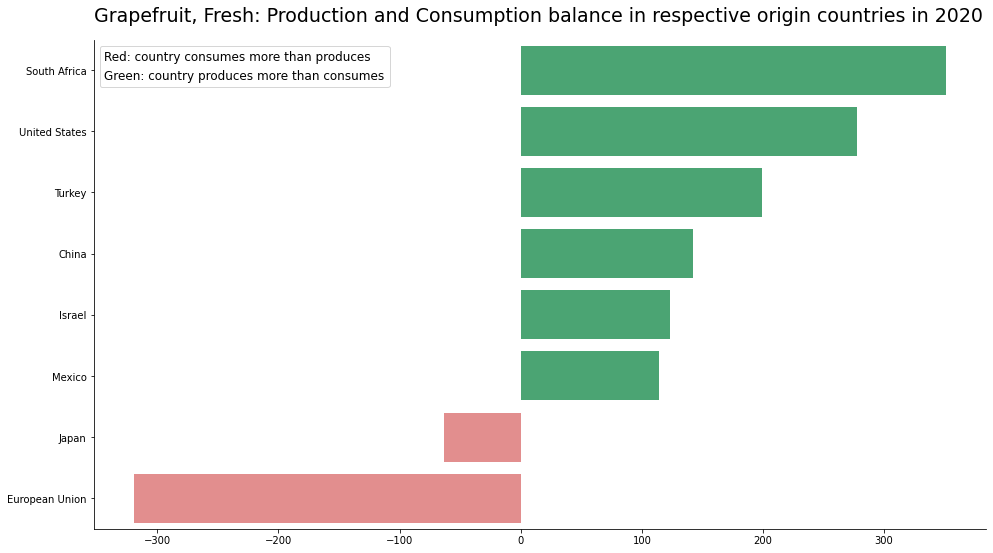

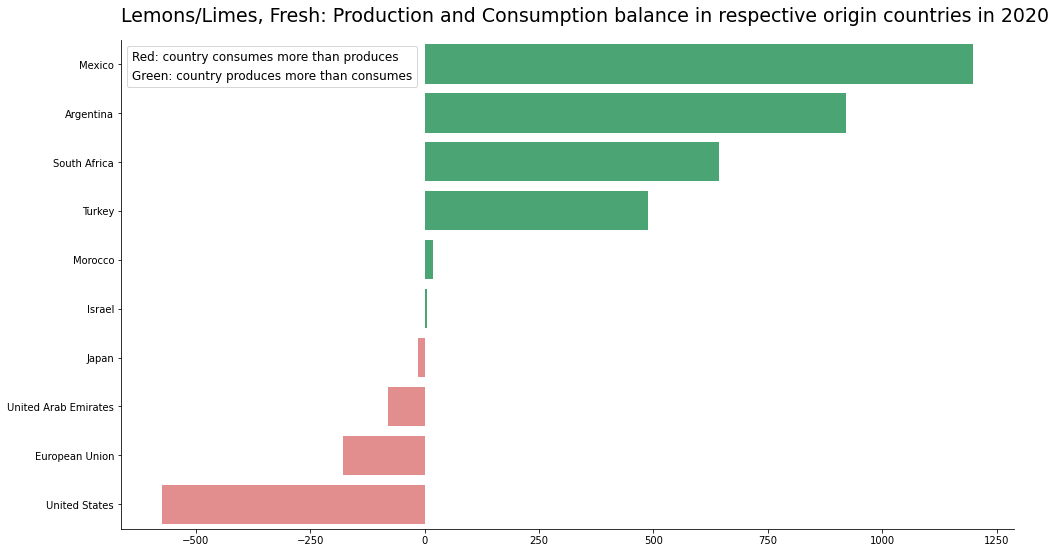

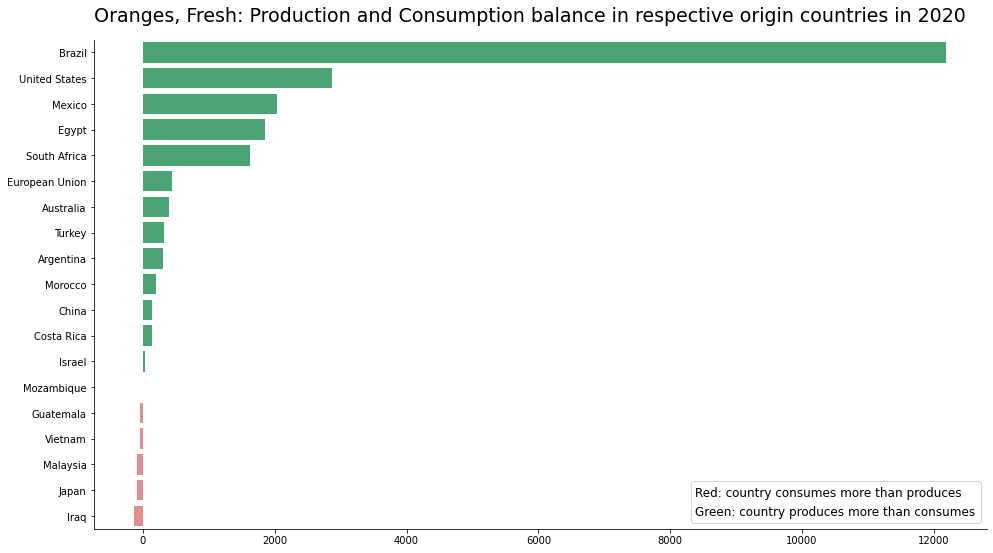

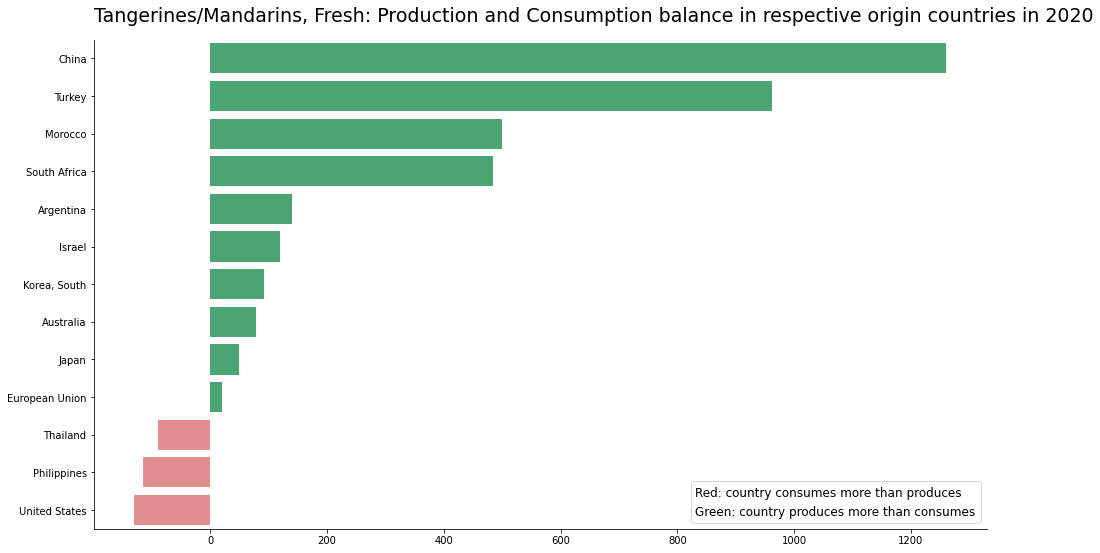

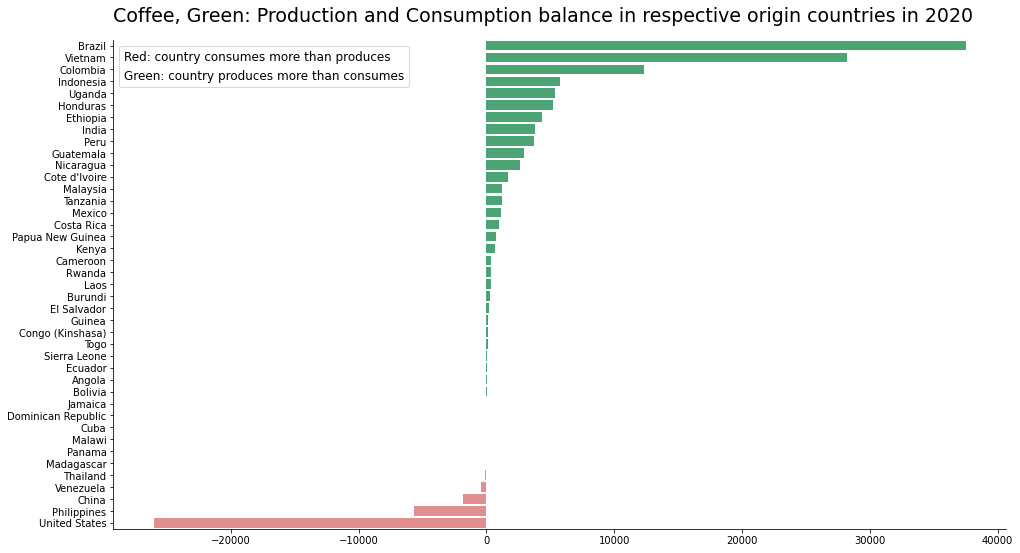

In [15]:
for commodity in commodities_to_explore:
    
    data = (filter_by_index(production_consumption_per_country_2020, commodity)
                .sort_values('Prod_Cons', ascending=False))
    
    plot_production_consumption_balance(data, commodity, 2020)

## 4.3 Percentage of consumption of commodity in the largest producers

In [16]:
largest_producers_per_commodity_rename_cols = \
    largest_producers_per_commodity.rename(columns={'Largest Producer':'Country_Name',
                                                    'Commodity':'Commodity_Description'})

production_consumption_2020_largest_producers = \
    (production_consumption_per_country_2020.reset_index()
         .merge(largest_producers_per_commodity_rename_cols))

production_consumption_2020_largest_producers['Perc_Cons'] = \
    round((production_consumption_2020_largest_producers['Consumption']*100
           / production_consumption_2020_largest_producers['Production']),
          2)

production_consumption_2020_largest_producers.sort_values('Perc_Cons', ascending=False, inplace=True)
production_consumption_2020_largest_producers.reset_index(drop=True, inplace=True)

##### Percentage of consumption of commodity for the largest producers

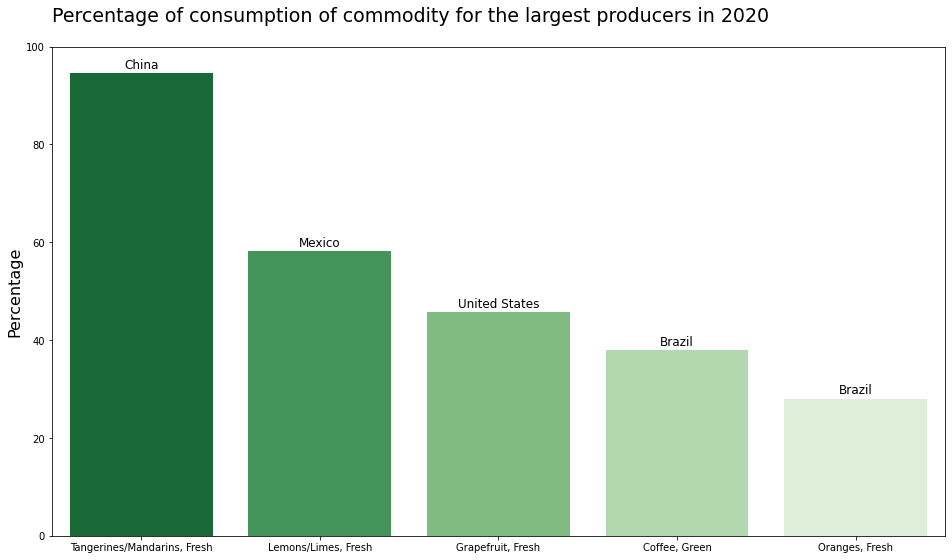

In [17]:
plt.figure(figsize=(16,9))

ax = sns.barplot(data=production_consumption_2020_largest_producers,
                    x='Commodity_Description',
                    y='Perc_Cons',
                    dodge=False,
                    palette="Greens_r")

ax.set_ylim(0,100)

plt.title("Percentage of consumption of commodity for the largest producers in 2020",
          fontsize=19, pad=25, loc='left')
plt.ylabel('Percentage', fontsize=16)
plt.xlabel('')

add_labels_to_bars(ax, production_consumption_2020_largest_producers['Country_Name'], 1.)

## 4.4 Stock level balance throughout the years

> Ending stocks = the unused commodity remaining at the end of the marketing year for use in the next year. \
> Beginning stocks = the ending stocks carried into the new marketing year from the previous year.

> Ending Stocks = Total Distribution - Total Exports - Total Domestic Consumption \
> Beginning Stocks = Total Supply - Production - Total Imports

In [18]:
ending_stock_fruits = \
    get_stock_df(df=commodities, func=calculate_ending_stocks_value,
                 commodities_no_stock_attributes=commodities_to_explore[:4],
                 attribute_description='Ending Stocks')

beginning_stock_fruits = \
    get_stock_df(df=commodities, func=calculate_beginning_stocks_value,
                 commodities_no_stock_attributes=commodities_to_explore[:4],
                 attribute_description='Beginning Stocks')

stock_coffee = \
    filter_stock_information(commodities, ['Coffee, Green'])


commodities_stock = \
    pd.concat([beginning_stock_fruits, ending_stock_fruits, stock_coffee], 
              ignore_index=True)

##### Stock level balance throughout the years

Commodities: Grapefruit, Fresh; Lemons/Limes, Fresh; Oranges, Fresh; Tangerines/Mandarins, Fresh; Coffee, Green
Commodity: Grapefruit, Fresh
Country: Brazil


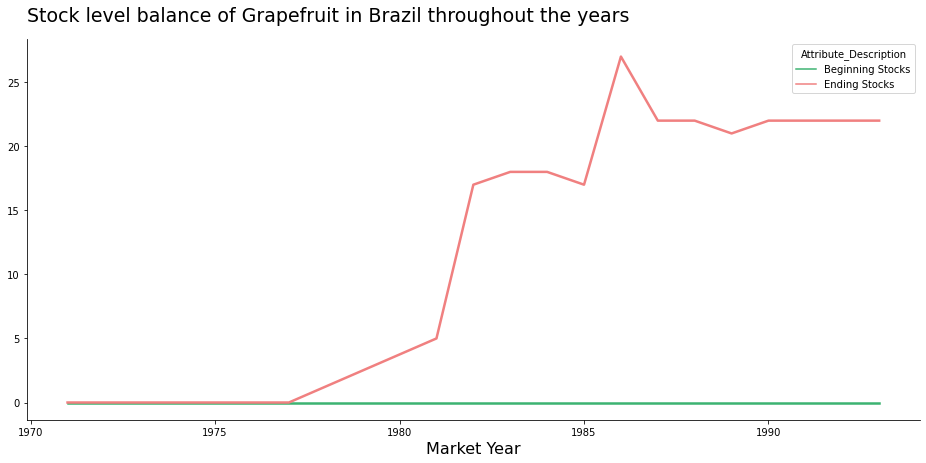

In [19]:
print('Commodities: '+'; '.join(commodities_to_explore))
commodity = input('Commodity: ')
country = input('Country: ')

plot_stock_level_balance(commodity_stock_df=commodities_stock,
                         commodity=commodity,
                         country=country)

## 4.5 Top 7 Exporters per Commodity in a year

Market Year: 2020


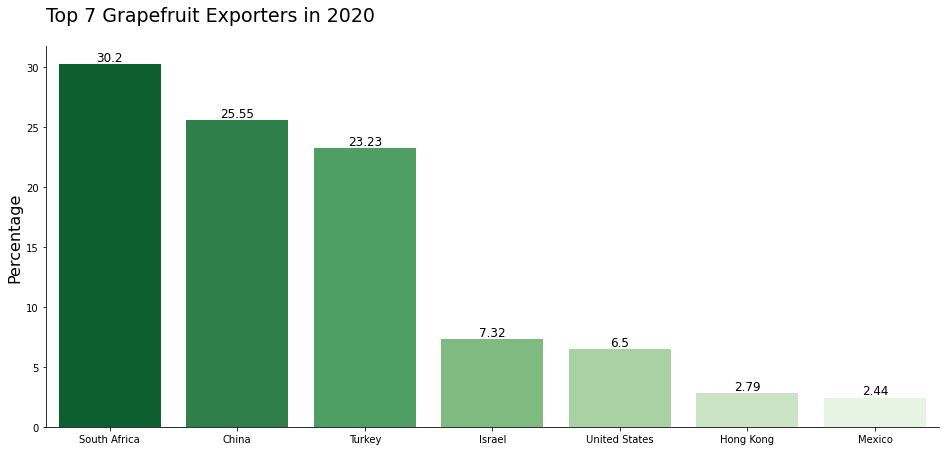

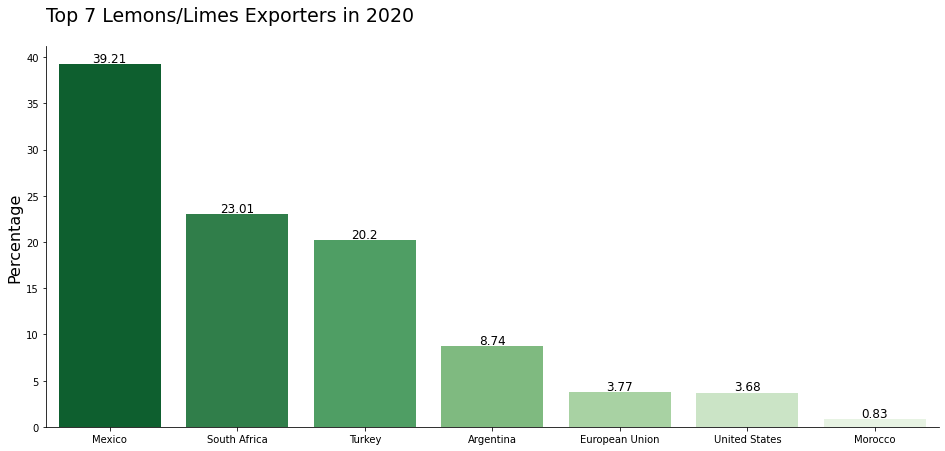

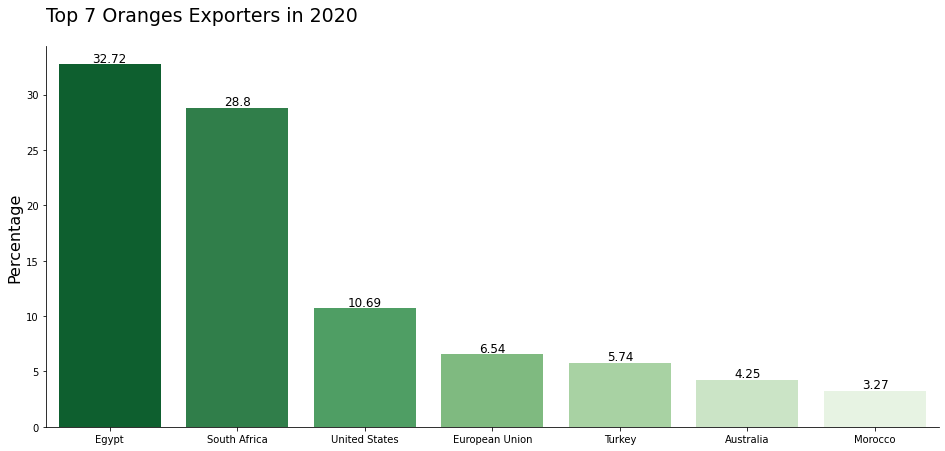

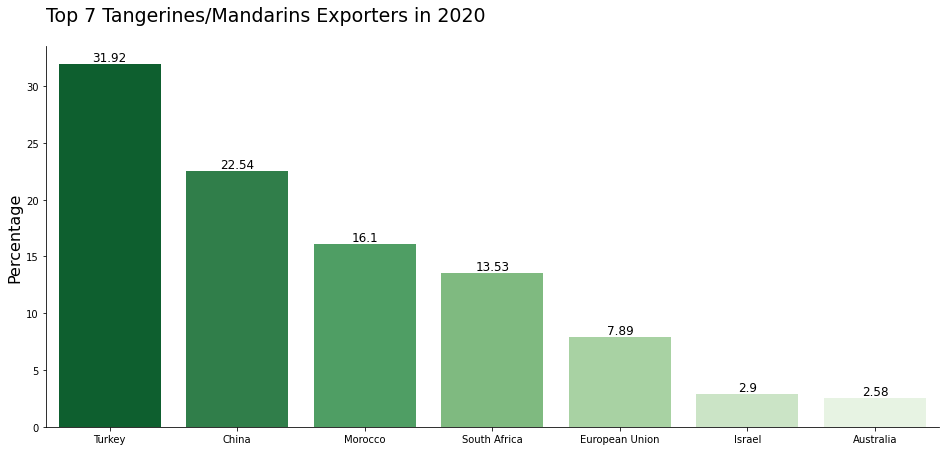

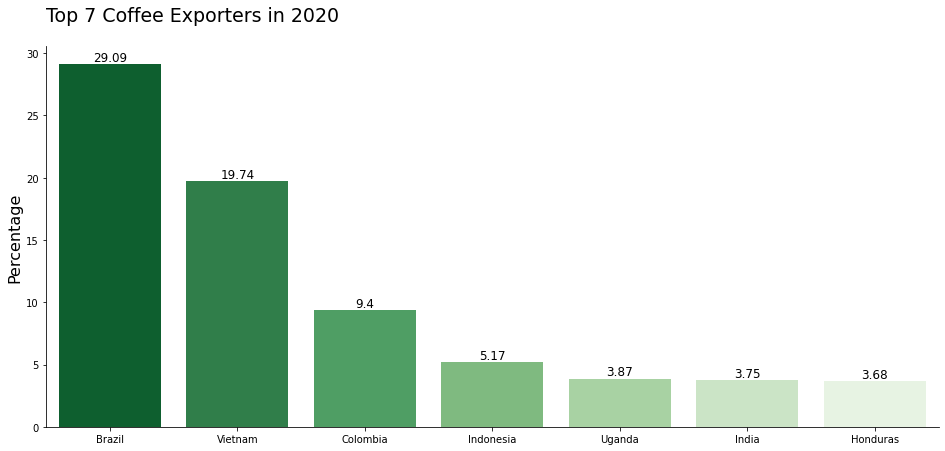

In [23]:
market_year = input('Market Year: ')


commodities_export = filter_by_values(filter_by_values(commodities, 'Attribute_Description', ['Exports']),
                                      'Market_Year', [market_year])

commodities_export_per_country_sorted = \
    (groupby_and_sum_values(commodities_export, ['Commodity_Description', 'Country_Name'])
         .sort_values(['Commodity_Description', 'Value']))

commodities_by_country_exports = get_top7_exporters_info_df(commodities_export)


for commodity in commodities_to_explore:
    
    plot_top7_exports_in_a_year(commodities_by_country_exports, commodity)